In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/results_20_epochs_ibm')
#path_results = Path('/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations')
path_results = Path('/media/discoD/models/elmo/ner/results')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/ner/results/harem-ft_ELMo
/media/discoD/models/elmo/ner/results/harem-ft_ELMo+CNN
/media/discoD/models/elmo/ner/results/harem-ft_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/results/harem-ft_ELMo+Embeddings
/media/discoD/models/elmo/ner/results/harem_ELMo
/media/discoD/models/elmo/ner/results/harem_ELMo+CNN
/media/discoD/models/elmo/ner/results/harem_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/results/harem_ELMo+Embeddings


In [4]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    results_model_folder = folder.iterdir()
    for training_folder in results_model_folder:
        #print('Reading files from %s' % training_folder.name)
        has_metrics = False
        for results_file in training_folder.iterdir():
            if results_file.name.endswith('.json'):
                #print('Parsing data from %s' % results_file.name)
                if results_file.name.startswith('config'):
                    configs[training_folder.name] = json.loads(results_file.read_bytes())
                elif results_file.name.startswith('metrics.'):
                    metrics[training_folder.name] = json.loads(results_file.read_bytes())
                    has_metrics = True
        if not has_metrics:
            print('metrics.json not found for %s' % training_folder.name)
            del configs[training_folder.name]
print(len(metrics))
print(len(configs))

metrics.json not found for harem_ELMo+CNN+Embeddings_fasttext_cbow_5_0
160
160


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str,'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
REPRESENTATION = 'Representation'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Representation',
 'Embedding',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    if len(data) == 4:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: 'No', EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[2], EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        #GloVe
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[3], EXECUTION_NUMBER: data[4]}
    elif len(data) == 6:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: data[3], TRAINING_NUMBER: data[4], EXECUTION_NUMBER: data[5]}
    else:
        print('Check id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['harem-ft', 'ELMo', '0', '0']
['harem-ft', 'ELMo', '1', '0']
['harem-ft', 'ELMo', '2', '0']
['harem-ft', 'ELMo', '3', '0']
['harem-ft', 'ELMo', '4', '0']
['harem-ft', 'ELMo+CNN', '0', '0']
['harem-ft', 'ELMo+CNN', '1', '0']
['harem-ft', 'ELMo+CNN', '2', '0']
['harem-ft', 'ELMo+CNN', '3', '0']
['harem-ft', 'ELMo+CNN', '4', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'wang2vec', 'cbow', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '1', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '2', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '3', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '4', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'skip', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'skip', '1', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'skip', '2', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'skip', '3', '0']
['harem-ft

In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
training_data_df = training_data_df[(training_data_df[TRAINING_NUMBER]).astype(int) < 5]
training_data_df 

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,harem-ft_ELMo_0_0,harem-ft,ELMo,No,No,0,0,11,20,00:46:22,2782.0,139.10,0.998377,0.998466,0.981112,0.980583,0.980847,3.849414,0.980111,0.982188,0.823232,0.831633,0.827411,62.998245,0.978612,0.980188,0.829522,0.799332,0.814147,77.248705
1,harem-ft_ELMo_1_0,harem-ft,ELMo,No,No,1,0,12,20,00:22:47,1367.0,68.35,0.997897,0.998055,0.978373,0.973635,0.975998,3.954796,0.989643,0.990540,0.879177,0.892950,0.886010,35.350330,0.978402,0.980203,0.823936,0.795326,0.809378,83.973366
2,harem-ft_ELMo_2_0,harem-ft,ELMo,No,No,2,0,13,20,00:19:09,1149.0,57.45,0.998137,0.998262,0.977649,0.976302,0.976975,3.855790,0.984376,0.985047,0.847082,0.893843,0.869835,59.390949,0.978462,0.980068,0.829060,0.809683,0.819257,83.609045
3,harem-ft_ELMo_3_0,harem-ft,ELMo,No,No,3,0,14,20,00:23:53,1433.0,71.65,0.997940,0.998052,0.975603,0.974546,0.975075,4.645464,0.982919,0.984265,0.823529,0.859951,0.841346,54.943508,0.979092,0.980653,0.826309,0.811686,0.818932,83.605297
4,harem-ft_ELMo_4_0,harem-ft,ELMo,No,No,4,0,19,20,00:23:58,1438.0,71.90,0.997613,0.997816,0.974673,0.971762,0.973215,4.479836,0.984349,0.985636,0.870416,0.853717,0.861985,62.107901,0.977951,0.979602,0.814072,0.799666,0.806805,100.175203
5,harem-ft_ELMo+CNN_0_0,harem-ft,ELMo+CNN,No,No,0,0,16,20,00:29:28,1768.0,88.40,0.998086,0.998276,0.977568,0.975458,0.976512,3.587718,0.980767,0.983281,0.831266,0.854592,0.842767,82.332504,0.978867,0.980443,0.820000,0.807679,0.813793,93.089778
6,harem-ft_ELMo+CNN_1_0,harem-ft,ELMo+CNN,No,No,1,0,17,20,00:25:10,1510.0,75.50,0.997874,0.998078,0.977640,0.976325,0.976982,4.509836,0.988150,0.989146,0.882199,0.879896,0.881046,41.372279,0.978702,0.980398,0.827420,0.802003,0.814513,92.398115
7,harem-ft_ELMo+CNN_2_0,harem-ft,ELMo+CNN,No,No,2,0,10,20,00:20:42,1242.0,62.10,0.998080,0.998262,0.976821,0.975475,0.976148,3.891977,0.985623,0.986773,0.865702,0.889597,0.877487,50.753713,0.978822,0.980728,0.846044,0.788982,0.816517,79.524829
8,harem-ft_ELMo+CNN_3_0,harem-ft,ELMo+CNN,No,No,3,0,17,20,00:24:48,1488.0,74.40,0.998063,0.998244,0.978804,0.975359,0.977079,3.890833,0.983333,0.984472,0.825287,0.882064,0.852732,64.977810,0.978266,0.979857,0.813907,0.809015,0.811453,89.032859
9,harem-ft_ELMo+CNN_4_0,harem-ft,ELMo+CNN,No,No,4,0,7,20,00:20:32,1232.0,61.60,0.997714,0.997895,0.972087,0.973934,0.973010,4.500066,0.984943,0.986132,0.891139,0.844125,0.866995,47.981324,0.978942,0.980638,0.832581,0.800334,0.816139,66.401399


In [10]:
training_data_df.to_csv('training_data_20_epochs_mestrado_all_reps.csv', index=None)

In [11]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'0:24:36.012500'

In [12]:
default_exported_columns = ['mean', 'min', 'max', 'std']
renamed_columns = ['Contagem', 'F-Score', 'Desvio Padrão', 'Mínimo', '25%', '50%', '75%', 'Máximo']
exported_columns_names = ['F-Score', 'Mínimo', 'Máximo', 'Desvio Padrão']
model_map = {'harem-ft': 'Sim', 'harem': 'Não'}
representation_map = {'ELMo+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo+Embeddings': 'ELMo+Vetor'}
embedding_type_map = {'skip': 'Skip-Gram', 'No': 'Sem Vetor', 'cbow': 'CBoW'}
embedding_map = {'wang2vec': 'Wang2Vec', 'glove': 'GloVe', 'word2vec': 'Word2Vec', 'No': 'Sem Vetor', 'fasttext': 'FastText'}
replacements_map = {**model_map, **representation_map, **embedding_type_map, **embedding_map}

def get_group_csv(index_names, group_name, group_columns, target_value, index_map, dataframe=training_data_df, exported_columns=default_exported_columns):
    if type(index_names) == str:
        index_names = [index_names]
    group = dataframe.groupby(group_columns).describe()[target_value].sort_values(by='mean', ascending=False)
    for column in exported_columns:
        group[column] = group[column] * 100
    group.index.names = index_names
    group = group.rename(index=index_map)
    group.columns = renamed_columns
    group.to_csv('grupo_' + group_name + '_20_epochs_mestrado_all_reps.csv', columns=exported_columns_names, float_format = '%.2f%%')
    return group

In [13]:
get_group_csv('Ajuste Fino', MODEL, MODEL, TEST_F1_MEASURE, model_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Ajuste Fino,,,,,,,,
Sim,80.0,81.338255,0.509224,79.451127,0.810643,0.814228,0.816581,82.192249
Não,80.0,81.175742,0.574123,79.414298,0.807727,0.812298,0.815556,82.436070


In [14]:
get_group_csv('Representação', REPRESENTATION, REPRESENTATION, TEST_F1_MEASURE, representation_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Representação,,,,,,,,
ELMo,10.0,81.300788,0.427652,80.680478,0.809670,0.813185,0.815703,81.925676
ELMo+Vetor,70.0,81.283360,0.579038,79.451127,0.809433,0.813828,0.816292,82.436070
ELMo+CNN+Vetor,70.0,81.249856,0.513652,79.724971,0.809609,0.812675,0.816466,82.229846
ELMo+CNN,10.0,81.078680,0.683675,79.414298,0.808676,0.812752,0.815522,81.651693


In [15]:
get_group_csv('Tipo de Vetor', EMBEDDING_TYPE, EMBEDDING_TYPE, TEST_F1_MEASURE, embedding_type_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Tipo de Vetor,,,,,,,,
Skip-Gram,60.0,81.438383,0.480269,80.300250,0.811634,0.814295,0.817560,82.436070
Sem Vetor,40.0,81.305926,0.529575,79.414298,0.810351,0.814339,0.816544,81.991165
CBoW,60.0,81.042996,0.555674,79.451127,0.807428,0.811080,0.814678,82.029527


In [16]:
get_group_csv('Vetor', EMBEDDING, EMBEDDING, TEST_F1_MEASURE, embedding_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Vetor,,,,,,,,
Wang2Vec,40.0,81.509874,0.482285,80.462506,0.811984,0.815015,0.818797,82.436070
GloVe,20.0,81.422119,0.475625,80.208860,0.813679,0.816218,0.816747,81.991165
Sem Vetor,20.0,81.189734,0.566584,79.414298,0.809139,0.813185,0.815928,81.925676
Word2Vec,40.0,81.165093,0.572792,79.836929,0.807798,0.813041,0.815694,82.192249
FastText,40.0,81.047101,0.506963,79.451127,0.808282,0.810852,0.814109,81.876694


In [17]:
get_group_csv(['Ajuste Fino', 'Representação', 'Vetor', 'Tipo de Vetor'], 'Model_Rep_Emb_Emb-Typ', [MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE], TEST_F1_MEASURE, replacements_map)

Contagem    F-Score  \
Ajuste Fino Representação  Vetor     Tipo de Vetor                        
Não         ELMo+Vetor     Wang2Vec  Skip-Gram           5.0  81.924638   
            ELMo+CNN+Vetor Wang2Vec  Skip-Gram           5.0  81.778396   
Sim         ELMo+Vetor     Wang2Vec  Skip-Gram           5.0  81.747334   
                           Word2Vec  Skip-Gram           5.0  81.690400   
                           GloVe     Sem Vetor           5.0  81.628224   
            ELMo+CNN+Vetor Wang2Vec  Skip-Gram           5.0  81.533340   
            ELMo+Vetor     Wang2Vec  CBoW                5.0  81.519755   
            ELMo+CNN+Vetor FastText  Skip-Gram           5.0  81.451659   
            ELMo+CNN       Sem Vetor Sem Vetor           5.0  81.448316   
Não         ELMo+CNN+Vetor Word2Vec  Skip-Gram           5.0  81.429719   
Sim         ELMo           Sem Vetor Sem Vetor           5.0  81.370382   
Não         ELMo+CNN+Vetor FastText  Skip-Gram           5.0  81.367230   
Sim         ELMo+CNN+Vetor GloVe     Sem Vetor           5.0  81.360941   
                           Wang2Vec  CBoW                5.0  81.352850   
Não         ELMo+Vetor     GloVe     Sem Vetor           5.0  81.352107   
            ELMo+CNN+Vetor GloVe     Sem Vetor           5.0  81.347203   
            ELMo+Vetor     Wang2Vec  CBoW                5.0  81.270568   
Sim         ELMo+Vetor     FastText  Skip-Gram           5.0  81.242848   
Não         ELMo           Sem Vetor Sem Vetor           5.0  81.231193   
Sim         ELMo+CNN+Vetor FastText  CBoW                5.0  81.125935   
                           Word2Vec  Skip-Gram           5.0  81.117015   
Não         ELMo+Vetor     Word2Vec  CBoW                5.0  81.106994   
Sim         ELMo+Vetor     Word2Vec  CBoW                5.0  81.009063   
Não         ELMo+Vetor     Word2Vec  Skip-Gram           5.0  80.996022   
            ELMo+CNN+Vetor Word2Vec  CBoW                5.0  80.991441   
            ELMo+Vetor     FastText  Skip-Gram           5.0  80.981991   
Sim         ELMo+CNN+Vetor Word2Vec  CBoW                5.0  80.980091   
Não         ELMo+CNN+Vetor Wang2Vec  CBoW                5.0  80.952112   
Sim         ELMo+Vetor     FastText  CBoW                5.0  80.833930   
Não         ELMo+CNN+Vetor FastText  CBoW                5.0  80.710045   
            ELMo+CNN       Sem Vetor Sem Vetor           5.0  80.709044   
            ELMo+Vetor     FastText  CBoW                5.0  80.663166   

                                                    Desvio Padrão     Mínimo  \
Ajuste Fino Representação  Vetor     Tipo de Vetor                             
Não         ELMo+Vetor     Wang2Vec  Skip-Gram           0.412727  81.474037   
            ELMo+CNN+Vetor Wang2Vec  Skip-Gram           0.426423  81.205312   
Sim         ELMo+Vetor     Wang2Vec  Skip-Gram           0.362181  81.285059   
                           Word2Vec  Skip-Gram           0.407292  81.281449   
                           GloVe     Sem Vetor           0.150401  81.416538   
            ELMo+CNN+Vetor Wang2Vec  Skip-Gram           0.475298  80.767272   
            ELMo+Vetor     Wang2Vec  CBoW                0.320966  81.223304   
            ELMo+CNN+Vetor FastText  Skip-Gram           0.269285  81.152181   
            ELMo+CNN       Sem Vetor Sem Vetor           0.203310  81.145345   
Não         ELMo+CNN+Vetor Word2Vec  Skip-Gram           0.548969  80.640717   
Sim         ELMo           Sem Vetor Sem Vetor           0.558289  80.680478   
Não         ELMo+CNN+Vetor FastText  Skip-Gram           0.230159  81.151566   
Sim         ELMo+CNN+Vetor GloVe     Sem Vetor           0.404331  80.865829   
                           Wang2Vec  CBoW                0.633488  80.462506   
Não         ELMo+Vetor     GloVe     Sem Vetor           0.623279  80.325960   
            ELMo+CNN+Vetor GloVe     Sem Vetor           0.655010  80.208860   
            ELMo+Vetor     Wang2Vec  CBoW                0.31

In [18]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,count,mean,std,min,25%,50%,75%,max
Embedding,Embedding_Type,,,,,,,,
wang2vec,skip,20.0,0.817459,0.004122,0.807673,0.814724,0.817591,0.820423,0.824361
glove,No,20.0,0.814221,0.004756,0.802089,0.813679,0.816218,0.816747,0.819912
word2vec,skip,20.0,0.813083,0.005372,0.803003,0.810574,0.813672,0.816588,0.821922
wang2vec,cbow,20.0,0.812738,0.004362,0.804625,0.810891,0.812712,0.815595,0.820295
fasttext,skip,20.0,0.812609,0.003274,0.807308,0.810886,0.812247,0.814381,0.818767
No,No,20.0,0.811897,0.005666,0.794143,0.809139,0.813185,0.815928,0.819257
word2vec,cbow,20.0,0.810219,0.005845,0.798369,0.807309,0.811674,0.814678,0.817272
fasttext,cbow,20.0,0.808333,0.005693,0.794511,0.806789,0.809070,0.811485,0.815458


In [19]:
training_data_skip_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'cbow']
training_data_skip_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
wang2vec,20.0,0.817459,0.004122,0.807673,0.814724,0.817591,0.820423,0.824361
glove,20.0,0.814221,0.004756,0.802089,0.813679,0.816218,0.816747,0.819912
word2vec,20.0,0.813083,0.005372,0.803003,0.810574,0.813672,0.816588,0.821922
fasttext,20.0,0.812609,0.003274,0.807308,0.810886,0.812247,0.814381,0.818767
No,20.0,0.811897,0.005666,0.794143,0.809139,0.813185,0.815928,0.819257


In [20]:
training_data_cbow_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'skip']
training_data_cbow_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
glove,20.0,0.814221,0.004756,0.802089,0.813679,0.816218,0.816747,0.819912
wang2vec,20.0,0.812738,0.004362,0.804625,0.810891,0.812712,0.815595,0.820295
No,20.0,0.811897,0.005666,0.794143,0.809139,0.813185,0.815928,0.819257
word2vec,20.0,0.810219,0.005845,0.798369,0.807309,0.811674,0.814678,0.817272
fasttext,20.0,0.808333,0.005693,0.794511,0.806789,0.809070,0.811485,0.815458


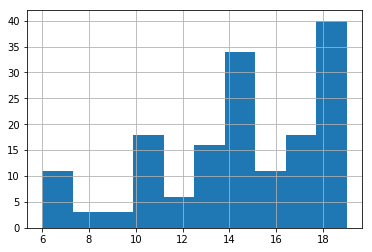

In [21]:
training_data_df[BEST_EPOCH].hist()

In [22]:
training_data_df[TOTAL_DURATION].describe()

count     160.000000
mean     1476.012500
std       318.284039
min      1141.000000
25%      1339.750000
50%      1428.500000
75%      1511.500000
max      2908.000000
Name: Total_Duration(s), dtype: float64

In [23]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
3,32.0,0.814209,0.004650,0.804090,0.810868,0.815252,0.817438,0.821922
2,32.0,0.813305,0.004511,0.798772,0.812415,0.814132,0.816253,0.820784
1,32.0,0.812821,0.004578,0.802089,0.809233,0.813831,0.816024,0.822298
0,32.0,0.811657,0.006060,0.794143,0.808350,0.812452,0.814475,0.824361
4,32.0,0.810858,0.006823,0.794511,0.806496,0.812518,0.816278,0.822815


In [24]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,160.0,0.81257,0.00547,0.000432,0.811716,0.813424


In [25]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
No,20,0.811897,0.005666,0.001267,0.809414,0.814381
fasttext,40,0.810471,0.005070,0.000802,0.808900,0.812042
glove,20,0.814221,0.004756,0.001064,0.812137,0.816306
wang2vec,40,0.815099,0.004823,0.000763,0.813604,0.816593
word2vec,40,0.811651,0.005728,0.000906,0.809876,0.813426


In [26]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [27]:
print_anova(EMBEDDING)

Overall model F( 4, 155) =  4.851, p =  0.00103144440807900468
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     4.851
Date:                Fri, 31 May 2019   Prob (F-statistic):            0.00103
Time:                        09:47:20   Log-Likelihood:                 616.25
No. Observations:                 160   AIC:                            -1223.
Df Residuals:                     155   BIC:                            -1207.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [35]:
training_data_df[(training_data_df.Embedding == 'wang2vec') & (training_data_df.Embedding_Type == 'skip') & (training_data_df.Representation == 'ELMo+Embeddings')]

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
65,harem-ft_ELMo+Embeddings_wang2vec_skip_0_0,harem-ft,ELMo+Embeddings,wang2vec,skip,0,0,11,20,00:29:56,1796.0,89.80,0.998433,0.998612,0.983771,0.980852,0.982309,2.933687,0.980221,0.982297,0.826733,0.852041,0.839196,64.771994,0.978206,0.979932,0.827909,0.798331,0.812851,80.755276
66,harem-ft_ELMo+Embeddings_wang2vec_skip_1_0,harem-ft,ELMo+Embeddings,wang2vec,skip,1,0,15,20,00:23:12,1392.0,69.60,0.998654,0.998722,0.983338,0.984396,0.983867,2.830908,0.988349,0.989345,0.882653,0.903394,0.892903,44.590681,0.979002,0.980758,0.823946,0.815693,0.819799,89.367576
67,harem-ft_ELMo+Embeddings_wang2vec_skip_2_0,harem-ft,ELMo+Embeddings,wang2vec,skip,2,0,17,20,00:19:31,1171.0,58.55,0.998467,0.998569,0.981236,0.979884,0.980560,3.197974,0.984856,0.985910,0.855397,0.891720,0.873181,66.529154,0.978432,0.980203,0.837913,0.804341,0.820784,103.374336
68,harem-ft_ELMo+Embeddings_wang2vec_skip_3_0,harem-ft,ELMo+Embeddings,wang2vec,skip,3,0,10,20,00:23:26,1406.0,70.30,0.998638,0.998761,0.984783,0.981316,0.983046,2.675114,0.982609,0.983747,0.834123,0.864865,0.849216,57.177565,0.979107,0.980623,0.826625,0.802337,0.814300,77.436336
69,harem-ft_ELMo+Embeddings_wang2vec_skip_4_0,harem-ft,ELMo+Embeddings,wang2vec,skip,4,0,13,20,00:23:48,1428.0,71.40,0.998540,0.998642,0.983184,0.984252,0.983718,3.310123,0.984151,0.985042,0.870416,0.853717,0.861985,55.164751,0.978882,0.980353,0.825322,0.814023,0.819634,83.847991
145,harem_ELMo+Embeddings_wang2vec_skip_0_0,harem,ELMo+Embeddings,wang2vec,skip,0,0,13,20,00:22:13,1333.0,66.65,0.998925,0.999004,0.986242,0.985976,0.986109,2.541221,0.980330,0.982625,0.818859,0.841837,0.830189,77.700663,0.979137,0.980893,0.830790,0.818030,0.824361,84.732031
146,harem_ELMo+Embeddings_wang2vec_skip_1_0,harem,ELMo+Embeddings,wang2vec,skip,1,0,18,20,00:29:27,1767.0,88.35,0.998892,0.998948,0.987864,0.985472,0.986667,2.464469,0.989942,0.991038,0.884319,0.898172,0.891192,44.987702,0.978086,0.979962,0.817479,0.812020,0.814740,104.140458
147,harem_ELMo+Embeddings_wang2vec_skip_2_0,harem,ELMo+Embeddings,wang2vec,skip,2,0,14,20,00:23:12,1392.0,69.60,0.998546,0.998614,0.982389,0.983742,0.983065,2.860507,0.986102,0.987060,0.859155,0.906582,0.882231,50.480653,0.978642,0.980443,0.826844,0.808347,0.817491,87.277864
148,harem_ELMo+Embeddings_wang2vec_skip_3_0,harem,ELMo+Embeddings,wang2vec,skip,3,0,13,20,00:23:24,1404.0,70.20,0.998334,0.998457,0.981853,0.981587,0.981720,3.199880,0.983954,0.984886,0.846336,0.879607,0.862651,59.977099,0.977486,0.979242,0.830059,0.804007,0.816825,86.797195
149,harem_ELMo+Embeddings_wang2vec_skip_4_0,harem,ELMo+Embeddings,wang2vec,skip,4,0,13,20,00:19:03,1143.0,57.15,0.998789,0.998869,0.984523,0.984523,0.984523,2.312391,0.987023,0.988311,0.901235,0.875300,0.888078,47.108205,0.978792,0.980533,0.831798,0.814023,0.822815,86.591906
